In [1]:
!pip install kagglehub torch torchvision matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import zipfile
import random

import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Config
IMG_SIZE    = (128, 128)
BATCH_SIZE  = 8
EPOCHS      = 100
LR          = 1e-3
DATA_ROOT   = "/content/rps_dataset"


In [3]:
import zipfile
import shutil

# Download dataset
path = kagglehub.dataset_download("sanikamal/rock-paper-scissors-dataset")
print("Downloaded to:", path)

# Cek apakah ada file ZIP
zip_files = [f for f in os.listdir(path) if f.lower().endswith(".zip")]
if zip_files:
    # Ekstrak ZIP
    zip_full = os.path.join(path, zip_files[0])
    with zipfile.ZipFile(zip_full, "r") as z:
        z.extractall(DATA_ROOT)
    print("Extracted ZIP to:", DATA_ROOT)
else:
    # Jika tidak ada ZIP, asumsikan dataset sudah di-folder
    os.makedirs(DATA_ROOT, exist_ok=True)
    for item in os.listdir(path):
        src = os.path.join(path, item)
        dst = os.path.join(DATA_ROOT, item)
        if os.path.isdir(src):
            shutil.copytree(src, dst, dirs_exist_ok=True)
        else:
            shutil.copy2(src, dst)
    print("Copied folder contents to:", DATA_ROOT)


100%|██████████| 452M/452M [00:03<00:00, 150MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1
Copied folder contents to: /content/rps_dataset


In [7]:
import os

BASE_DIR = os.path.join(DATA_ROOT, "Rock-Paper-Scissors")

for split in ["train", "test", "validation"]:
    split_dir = os.path.join(BASE_DIR, split)
    if os.path.isdir(split_dir):
        print(f"\n=== {split.upper()} ===")
        for cls in sorted(os.listdir(split_dir)):
            cls_dir = os.path.join(split_dir, cls)
            if os.path.isdir(cls_dir):
                imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png'))]
                print(f"{cls:>12}: {len(imgs)} images")
    else:
        print(f"Folder not found: {split_dir}")


=== TRAIN ===
       paper: 840 images
        rock: 840 images
    scissors: 840 images

=== TEST ===
       paper: 124 images
        rock: 124 images
    scissors: 124 images

=== VALIDATION ===


In [9]:
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, split, img_size=(128,128), scale='tanh', augment=False, max_samples=None):
        self.split_dir = os.path.join(BASE_DIR, split)
        # rekursif cari semua .jpg/.png
        files = []
        for root, _, fnames in os.walk(self.split_dir):
            for fname in fnames:
                if fname.lower().endswith(('.jpg','.png')):
                    files.append(os.path.join(root, fname))
        # batasi jumlah sampel
        if max_samples is not None:
            files = files[:max_samples]
        self.files    = files
        self.img_size = img_size
        self.scale    = scale
        self.augment  = augment

    def __len__(self):
        return len(self.files)

    def preprocess(self, img, mode):
        img = img.convert(mode).resize(self.img_size)
        arr = np.array(img).astype('float32')
        if self.scale=='tanh':
            arr = (arr / 127.5) - 1.0
        else:
            arr /= 255.0
        return arr

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.augment and random.random() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

        gray_arr  = self.preprocess(img, 'L')      # (H, W)
        color_arr = self.preprocess(img, 'RGB')    # (H, W, 3)
        gray_arr  = np.repeat(gray_arr[:,:,None], 3, axis=-1)

        gray_t  = torch.tensor(gray_arr).permute(2,0,1).float()
        color_t = torch.tensor(color_arr).permute(2,0,1).float()
        return gray_t, color_t

# instantiate dengan batas 50 sampel untuk train
train_ds = ColorizationDataset("train",      IMG_SIZE, scale='tanh', augment=True,  max_samples=50)
val_ds   = ColorizationDataset("validation", IMG_SIZE, scale='tanh', augment=False, max_samples=50)
test_ds  = ColorizationDataset("test",       IMG_SIZE, scale='tanh', augment=False, max_samples=50)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Samples → train: {len(train_ds)},  val: {len(val_ds)},  test: {len(test_ds)}")

Samples → train: 50,  val: 33,  test: 50


In [10]:
class DeeperAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = DeeperAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [11]:
for epoch in range(EPOCHS):
    # — TRAIN —
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # — VALIDATION —
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()

    # — TEST —
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            test_loss += criterion(model(xb), yb).item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}  "
              f"Train Loss: {train_loss/len(train_dl):.4f}  "
              f"Val Loss:   {val_loss/len(val_dl):.4f}  "
              f"Test Loss:  {test_loss/len(test_dl):.4f}")


Epoch 10/100  Train Loss: 0.0246  Val Loss:   0.0212  Test Loss:  0.0217
Epoch 20/100  Train Loss: 0.0127  Val Loss:   0.0105  Test Loss:  0.0114
Epoch 30/100  Train Loss: 0.0089  Val Loss:   0.0073  Test Loss:  0.0093
Epoch 40/100  Train Loss: 0.0068  Val Loss:   0.0057  Test Loss:  0.0071
Epoch 50/100  Train Loss: 0.0060  Val Loss:   0.0050  Test Loss:  0.0066
Epoch 60/100  Train Loss: 0.0045  Val Loss:   0.0046  Test Loss:  0.0056
Epoch 70/100  Train Loss: 0.0047  Val Loss:   0.0038  Test Loss:  0.0057
Epoch 80/100  Train Loss: 0.0041  Val Loss:   0.0042  Test Loss:  0.0049
Epoch 90/100  Train Loss: 0.0033  Val Loss:   0.0035  Test Loss:  0.0046
Epoch 100/100  Train Loss: 0.0030  Val Loss:   0.0028  Test Loss:  0.0044


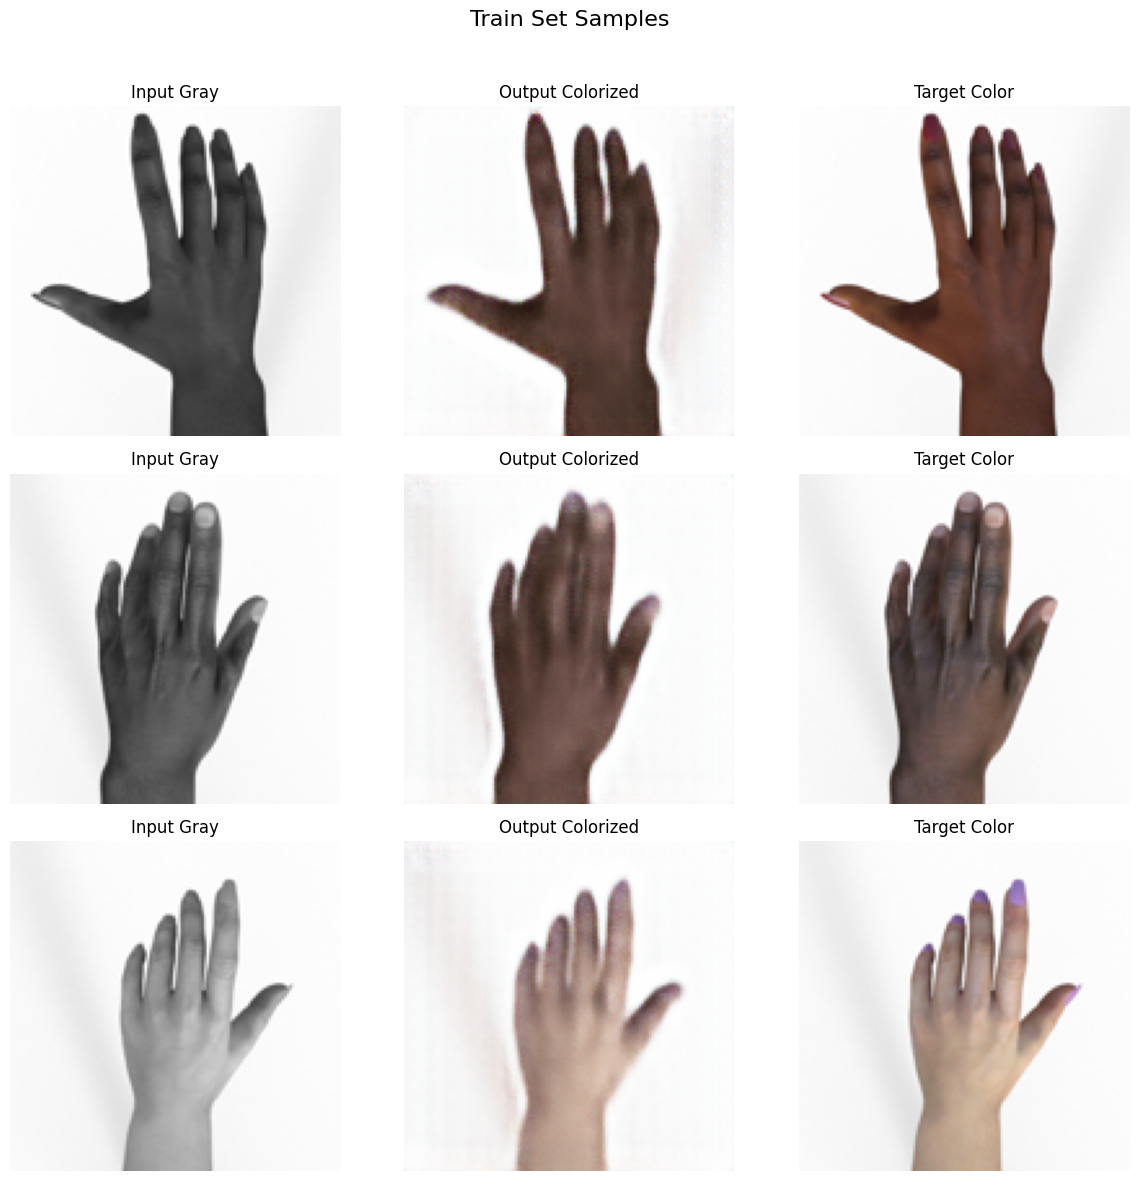

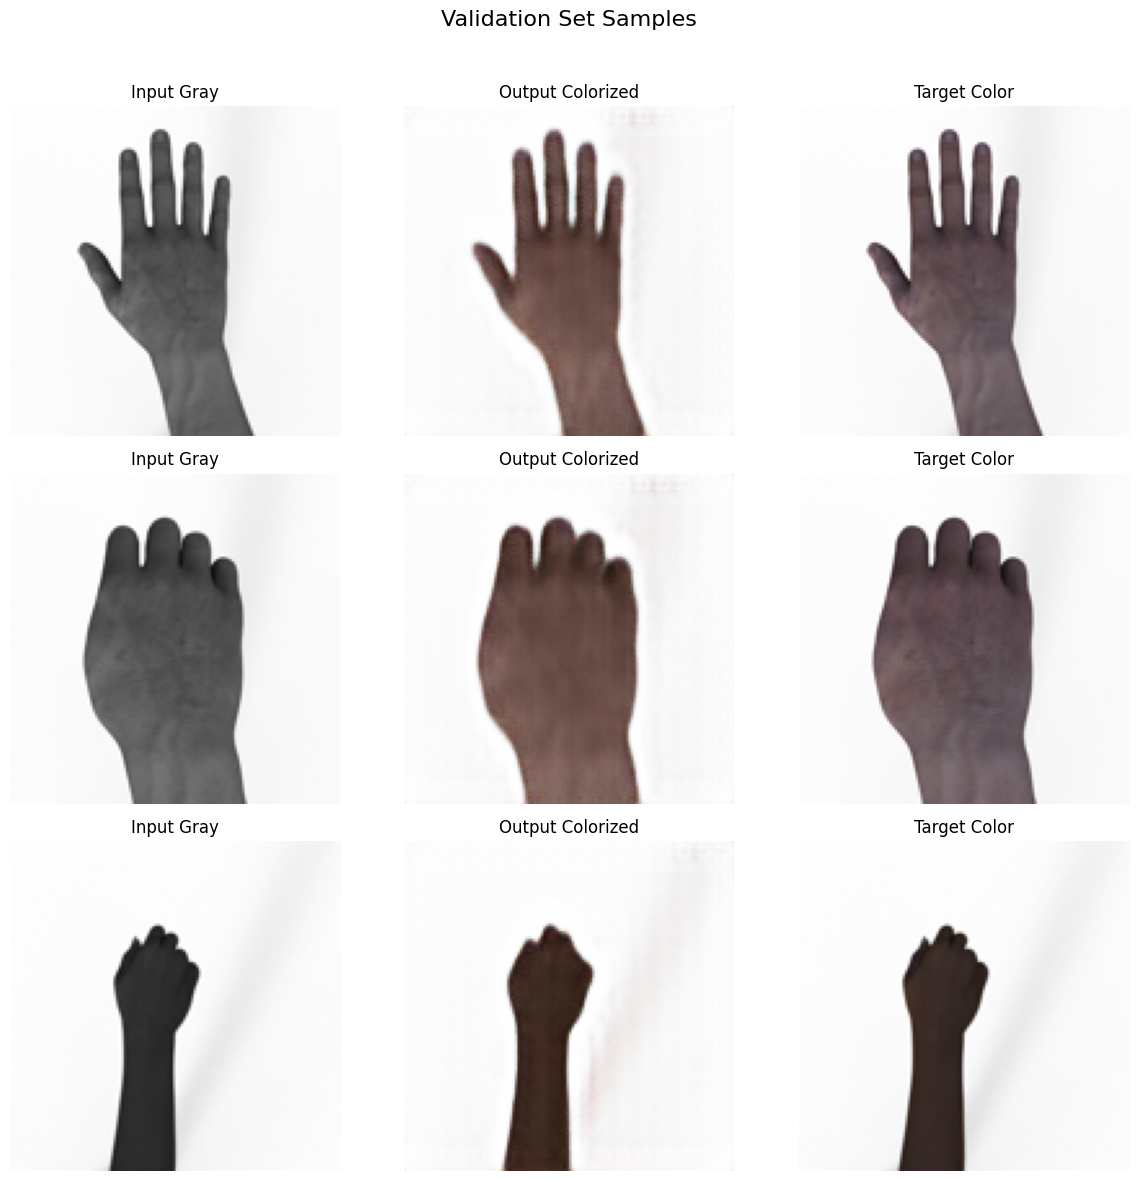

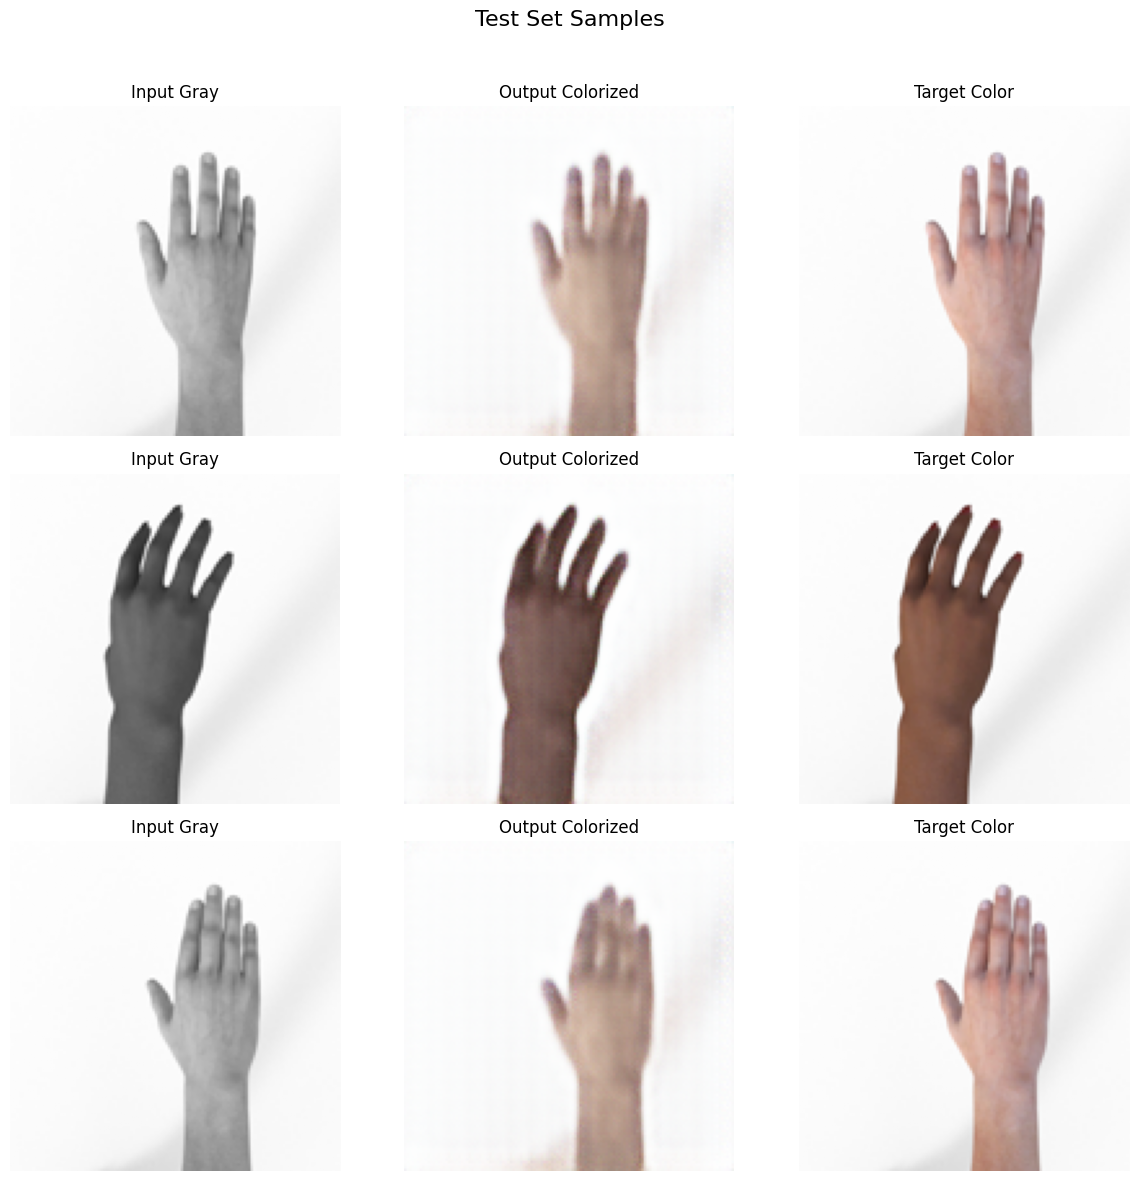

In [12]:
import matplotlib.pyplot as plt

def visualize(dataset, title, n=5):
    model.eval()
    fig, axs = plt.subplots(n, 3, figsize=(12, 4*n))
    with torch.no_grad():
        for i in range(n):
            g, c = dataset[i]
            out = model(g.unsqueeze(0).to(device)).squeeze().cpu()
            inp = ((g.permute(1,2,0).numpy() + 1)/2).clip(0,1)
            outp= ((out.permute(1,2,0).numpy()+ 1)/2).clip(0,1)
            tgt = ((c.permute(1,2,0).numpy()+ 1)/2).clip(0,1)

            axs[i,0].imshow(inp) ; axs[i,0].set_title("Input Gray")
            axs[i,1].imshow(outp); axs[i,1].set_title("Output Colorized")
            axs[i,2].imshow(tgt) ; axs[i,2].set_title("Target Color")
            for ax in axs[i]: ax.axis("off")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

# Visualisasi contoh:
visualize(train_ds,  "Train Set Samples",      n=3)
visualize(val_ds,    "Validation Set Samples", n=3)
visualize(test_ds,   "Test Set Samples",       n=3)
